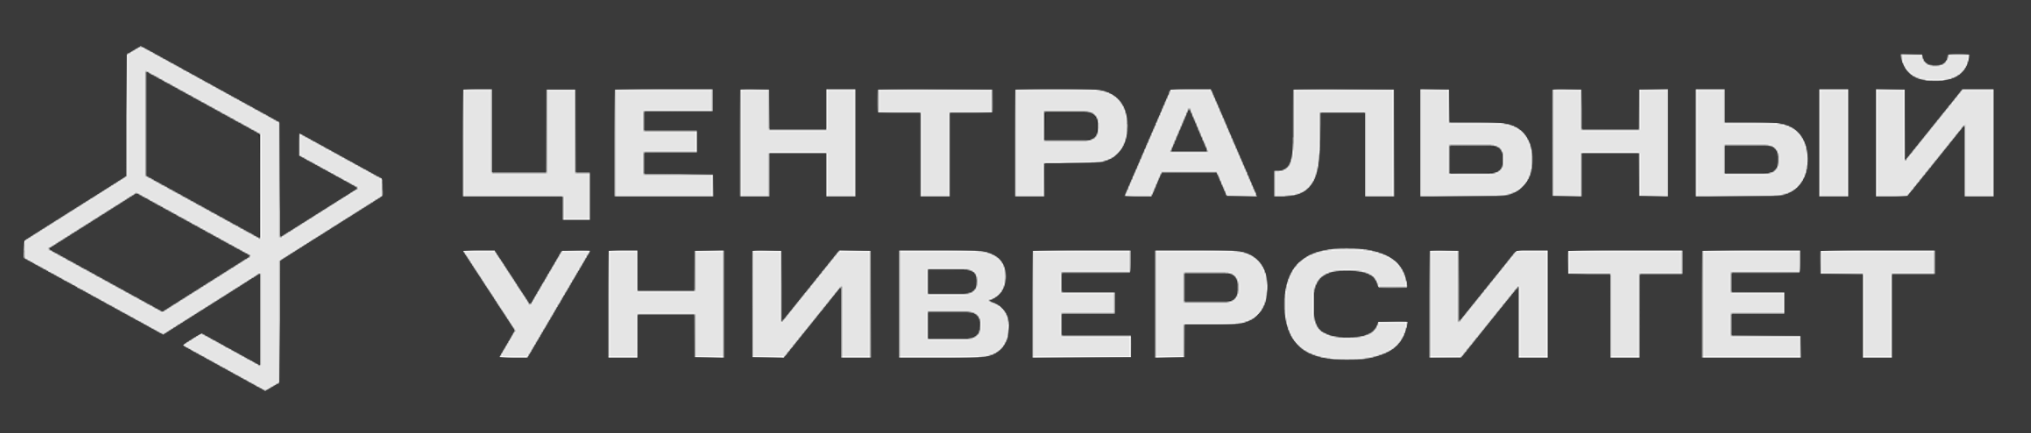

# Домашнее задание 8. Generative models.

## Максимальное кол-во баллов: 100

___
## Cроки

Дата выдачи: TBD

Жесткий дедлайн: TBD



---

# Важно! О формате сдачи

* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**
*  **Если в ячейке написана фраза "Вывод"/"Ответ на вопрос"/"Ваш текст" и пр., то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно).**
* **Если в ячейке написано "Your code here"/"Ваш код" и пр., то ожидается ответ в виде кода (можете добавить больше ячеек с кодом, если считаете это необходимым, но это необязательно).**
* **Если есть и ячейка с фразой "Вывод" и пр., и ячейка с фразой "Your code here" и пр., то в ответе ожидается и код, и текст)**
* **Если в формулировке задания явно не указывается сигнатура функции, можно пользоваться своими методами**
___


Привет! В этой домашке тебе предстоит подчинить себе генерацию, а именно реализовать conditional-варианты архитектур VAE/GAN

**Важно**: 
1. архитектуры должны быть реализованы при помощи сверточных слоев `nn.Conv2d`, решения без сверток засчитываться не будут, но можно добавлять `nn.Linear` по необходимости
2. чекпоинты, ноутбук и используемые модули(архитектуры рекомендуется разбить на модули для читаемости) должны быть прикреплены к решению
3. можешь оставить requirements.txt чтобы облегчить проверяющим жизнь

---

## <font color='orange'>Задание 0: Данные [5 баллов]</font>

Работать будем с хорошо известным вам датасетом циферок, ниже его надо будет скачать при помощи `torchvision API`

![](https://user-images.githubusercontent.com/47734496/60438108-8b894000-9c2d-11e9-9cbb-1c06e3fb90a7.png)

Размер картинок: 28x28x1, трейн/тест сплиты: 60000, 10000

Лики данных допустимы, можете использовать все данные как трейн, только оставьте какую-то часть на валидацию(понадобится для графиков функций потерь)

---

### 0.1. [5 баллов]
### Формулировка задания:

1. Визуализируй семплы из датесетов для твоего:
- трейна
- инференса
2. Выведи размеры train/val сплитов


Нормализовывать картинки не обязательно, используй референсы ниже как пример

In [ ]:


class ImageDataset(Dataset):
    def __init__(self, folder, split=None, transform=None):
        # call parent contruction method
        super().__init__()
        
        self.class_names = np.loadtxt(os.path.join(folder, 'class_names.npy'), dtype=str)
        self.img_dim = 28
        
        if split.lower() not in ['train', 'val', 'test']:
            raise Exception('wrong split encountered')
        
        self.images = np.load(os.path.join(folder, f'{split.lower()}_images.npy')).astype(np.uint8)
        self.labels = np.load(os.path.join(folder, f'{split.lower()}_labels.npy')) if split.lower() != 'test' else None
        
        self.transform = transform
        
        print(f'{split.lower()} split loaded successfully')
        
    def __getitem__(self, idx):
        imgs = self.images[idx]
        
        if self.transform:
            imgs = self.transform(imgs.reshape(self.img_dim, self.img_dim, 1))
        
        return imgs, self.labels[idx] if self.labels is not None else -1
    
    def __len__(self):
        return len(self.images)

In [210]:
from torch.utils.data import DataLoader
import torchvision.transforms as TT
import numpy as np
import torch
import os

train_transforms = TT.Compose([
    TT.ToTensor(),
    TT.Normalize(mean=[0.5], std=[0.5])
]) 

val_transforms = TT.Compose([
    TT.ToTensor(),
    TT.Normalize(mean=[0.5], std=[0.5])
]) 

In [211]:
import matplotlib.pyplot as plt
import numpy as np

def show_transforms(data=None, num_images=2):

    plt.style.use('dark_background')

    indices = np.random.choice(range(len(data)), size=num_images, replace=False)

    _, axes = plt.subplots(ncols=num_images, figsize=(10, 5))

    for idx, ax in zip(indices, axes.T):
        
        img, label_id = data[idx]
        
        title = data.classes[label_id]

        ax.imshow((img.permute(1, 2, 0) + 1) / 2, cmap='gray')      
        ax.set_title(title)

        ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.style.use('default')

In [ ]:
from torchvision.datasets import MNIST

train_dataset = MNIST(root='mnist_dataset', train=True, transform=train_transforms, download=True)
val_dataset = MNIST(root='mnist_dataset', train=False, transform=val_transforms, download=True)

len(train_dataset), len(val_dataset)

(60000, 10000)

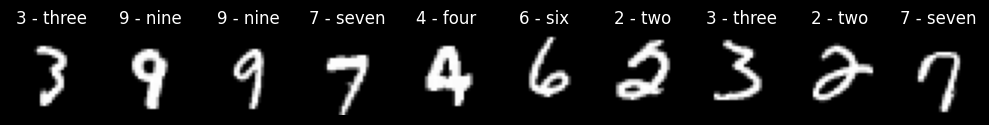

In [7]:
show_transforms(train_dataset, num_images=10)

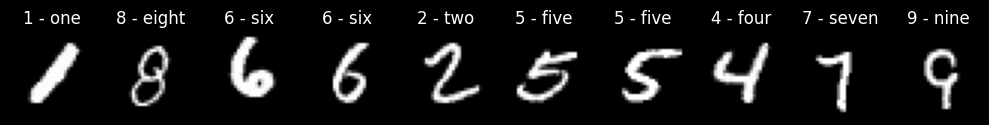

In [8]:
show_transforms(val_dataset, num_images=10)

In [9]:
BATCH_SIZE = 1024
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, pin_memory=True)

---

## <font color='orange'>Задание 1: Conditional VAE [50 баллов] + 5 баллов за функцию метрики</font>

![](https://drive.google.com/uc?export=view&id=1-GQwHMBFpY8W1hiOO_yuIOh8yfcAox6D)

![](https://drive.google.com/uc?export=view&id=1DIAUPy88plSiuA8n9ElkLnmg8nTd-vuH)

Note: подумай как еще можно закодировать лейблы с помощью `nn.Embedding`. Скорее всего, так будет лучше учиться

---

### 1.1. [10 баллов]
### Формулировка задания:

Реализуй conditional-автоэнкодер, можешь использовать картинку выше как референс, не запрещается использовать более интересные подходы

Артефактом к данному пункту будет служить модуль с автоэнкодером или клетка с объявлением класса

In [10]:
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch

cudnn.benchmark = True

In [11]:
from IPython.display import clear_output
from torchvision.utils import make_grid
from tqdm import tqdm


def train_autoencoder(model=None, optimizer=None, loss_fn=None, train_loader=None, val_loader=None, n_epochs=0, log_step=1, device=None):
    
    model.to(device)
    
    train_loss_history = []
    val_loss_history = []

    fixed_noize = torch.randn(model.num_classes, model.hidden_dim)
    
    for epoch_id in range(n_epochs):

        model.train()
        
        loss_acc = 0.
        denom = 0
    
        for img, label in tqdm(train_loader, desc='train iter', leave=True, total=len(train_loader)):

            optimizer.zero_grad()
            
            B = img.shape[0]
            
            mu, log_sigma, reconstruction = model(img.to(device), label.to(device))
            
            loss = loss_fn(mu, log_sigma, reconstruction, img.to(device))
            loss.backward()
            
            optimizer.step()
            
            loss_acc += loss.item() * B
            denom += B
            
        loss_acc /= denom
        
        if epoch_id % log_step == 0:
            
            train_loss_history.append(loss_acc)
        
            with torch.no_grad():

                model.eval()

                loss_acc = 0.
                denom = 0

                for img, label in tqdm(val_loader, desc='val iter', leave=True, total=len(val_loader)):
                    
                    B = img.shape[0]

                    mu, log_sigma, reconstruction = model(img.to(device), label.to(device))

                    loss = loss_fn(mu, log_sigma, reconstruction, img.to(device))
                                        
                    loss_acc += loss.item() * B
                    denom += B

                loss_acc /= denom

                val_loss_history.append(loss_acc)

                clear_output(wait=True)

                _, axes = plt.subplots(ncols=2, figsize=(13, 5), layout='constrained')
                    
                axes[0].plot(train_loss_history, label='train loss')
                axes[0].legend()

                axes[0].plot(val_loss_history, label='val loss')
                axes[0].legend()

                generated = model.sample(hidden_state=fixed_noize, targets=torch.arange(model.num_classes).to(device), device=device).cpu()

                axes[1].imshow(
                    make_grid((generated.reshape(-1, 1, 28, 28) + 1) / 2, nrow=model.num_classes).permute(1, 2, 0),
                )
                axes[1].axis('off')
                
                plt.suptitle(f'epoch #{epoch_id+1}/{n_epochs}')
                plt.show()

In [12]:
def vae_loss(mu, log_sigma, reconstruction, x):
    B = reconstruction.shape[0]
    mse = F.mse_loss(reconstruction.view(B,-1), x.view(B, -1), reduction='none').sum(1)
    kld = -0.5 * (1 + log_sigma - mu.pow(2) - log_sigma.exp()).sum(1)
    return (mse + kld).mean()

In [13]:
from cvae import CVAE
import torch

D = 128

model = CVAE(num_classes=10, hidden_dim=D, num_filters=64)

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, amsgrad=True)

---

### 1.2. [5 баллов]
### Формулировка задания:

Обучи модель и визуализируй историю лоссов по эпохам на train/val сплитах(вторая картинка на референсе необязательная)

Должно получиться что-то похожее на референсную картинку ниже

Артефакт: веса обученной модели

In [17]:
config = dict(
    model=model,
    optimizer=optimizer,
    loss_fn=vae_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    log_step=5,
    n_epochs=100,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
)

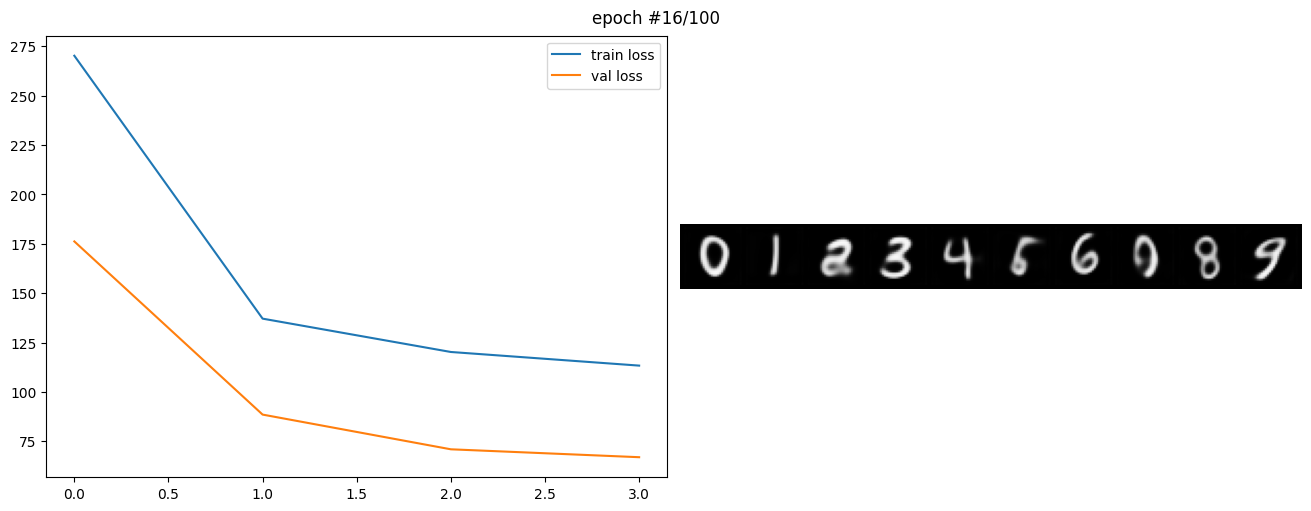

train iter:  32%|███▏      | 19/59 [00:14<00:30,  1.31it/s]


KeyboardInterrupt: 

In [18]:
train_autoencoder(
    **config
)

In [19]:
torch.save(model.state_dict(), 'cvae.ckpt')

---

### 1.3. [5 баллов]
### Формулировка задания:

1. Реализуй функцию `show_grid_vae(...)`, используя шаблон ниже

2. Визуализируй результат для `digit=4, n_reps=9`

3. Добавь код загрузки весов обученной модели, чтобы проверяющему было удобно воспроизвести твой код

In [227]:
@torch.no_grad
def show_grid_vae(model=None, digit=0, n_reps=1, device=None):
    """
    Визуализатор семлов CVAE.
            Параметры:
                    model torch.nn.Module: модель CVAE
                    digit (int): генерируемая цифра
                    n_reps (int): кол-во семплов
                    device torch.device: девайс
            Возвращаемое значение:
                    None
    """


    model.to(device)
    model.eval()

    noise = torch.randn(n_reps, model.hidden_dim)

    targets = (torch.ones(n_reps) * digit).long()
    grid = model.sample(hidden_state=noise.to(device), targets=targets.to(device), device=device).cpu()

    plt.imshow(
        make_grid((grid + 1) / 2, nrow=np.sqrt(n_reps).astype(int)).permute(1, 2, 0),
    )

    plt.axis('off')
    plt.show()

Пример:

In [216]:
checkpoint = torch.load('cvae.ckpt', map_location='cpu')

model = CVAE(num_classes=10, hidden_dim=128, num_filters=64)
model.load_state_dict(checkpoint)

<All keys matched successfully>

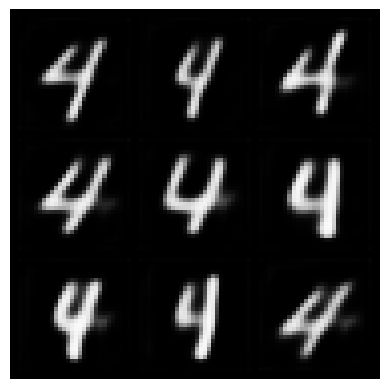

In [220]:
show_grid_vae(
    model=model,
    digit=4,
    n_reps=9, 
    device=DEVICE
)

---

### 1.4. [30 баллов] + 5 баллов за корректную реализацию функции из п.п. 1
### Формулировка задания:

1. Реализуй функцию ```compute_acc_vae(...)```, используя шаблон ниже

Итоговый балл за этот пункт рассчитывается по формуле:

- int(mean_acc * 30), где mean_acc лежит в [0, 1]

In [ ]:
from tqdm.notebook import tqdm
import numpy as np

from lenet import LeNet5

classiffier_model = LeNet5().eval()
classiffier_model.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth', weights_only=True))
classiffier_model = classiffier_model.to(DEVICE)

transform = TT.Compose([
    TT.Resize(size=(32, 32), antialias=True)
])

In [ ]:
@torch.no_grad
def compute_acc_vae(model=None, n_reps=1, device=None):
    """
    CVAE accuracy.
    Алгоритм:
        1. цикл по цифрам
            a. генерируем n_reps цифр с одинаковым лейблом D
            b. считаем accuracy классификатора classiffier_model (в идеале все предикты должны быть D)
            с. сохраняем результат усредненной метрики в буфер 
        
        2. Считаем (mean, std) для получившегося буфера
        3. Возвращаем (mean, std)

            Параметры:
                    model torch.nn.Module: модель CVAE
                    n_reps (int): кол-во семплов
                    device torch.device: девайс
            Возвращаемое значение:
                    (mean, std) рассчитаные по цифрам
    """
    
    model.to(device)
    model.eval()

    scores = []
    
    for class_id in tqdm(range(10)):

        noise = torch.randn(n_reps, model.hidden_dim)

        targets = (torch.ones(n_reps) * class_id).long()
        generated = model.sample(hidden_state=noise.to(device), targets=targets.to(device), device=device)

        input_ = (transform(generated)  + 1) / 2

        preds = F.softmax(
            classiffier_model(input_),
            dim=1
        ).cpu().numpy()

        acc = (preds.argmax(1) == targets.numpy()).astype(int).sum() / n_reps
        scores.append(acc)

    return np.mean(scores), np.std(scores)

In [225]:
mu, sigma = compute_acc_vae(
    model=model,
    n_reps=100,
    device=DEVICE
)

mu, sigma

  0%|          | 0/10 [00:00<?, ?it/s]

(0.9399999999999998, 0.06708203932499368)

---

## <font color='orange'>Задание 2: Conditional GAN [2 балла]</font>

---

### 2.1. [10 баллов]
### Формулировка задания:

Реализуй conditional-GAN, можешь использовать картинку выше как референс, не запрещается использовать более интересные подходы

Артефактом к данному пункту будет служить модуль с автоэнкодером или клетка с объявлением класса

In [75]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
from torchvision.utils import make_grid

def train_gan(model=None, loader=None, optimizer=None, criterion=None, n_epochs=1, device=None, log_step=1):
    model['discriminator'].train()
    
    # log losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch_id in tqdm(range(n_epochs), desc='train loop', leave=True):
        
        # because we call .eval() for vizualization
        model['generator'].train()
        
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        
        for real_images, labels in tqdm(loader, desc='batch iterations', leave=False):
            
            real_images = real_images.to(device)
            labels = labels.to(device)
            B = real_images.shape[0]
            
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ## clear D gradients
            optimizer['discriminator'].zero_grad()

            ## pass real images through D
            
            real_preds = model['discriminator'](real_images, targets=labels)
            real_targets = torch.ones(B, 1, device=device)
            real_loss = criterion['discriminator'](real_preds, real_targets)
            real_loss.backward()
            torch.nn.utils.clip_grad_norm_(model['discriminator'].parameters(), max_norm=10.)
            
            cur_real_score = torch.mean(torch.sigmoid(real_preds)).item()
            
            ## generate fake images
            
            fake_images = model['generator'](batch_size=B, targets=labels, device=device)

            ## pass fake images through D
            
            fake_targets = torch.zeros(B, 1, device=device)
            fake_preds = model['discriminator'](fake_images.detach(), targets=labels)
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)
            fake_loss.backward()
            torch.nn.utils.clip_grad_norm_(model['discriminator'].parameters(), max_norm=10.)
            
            cur_fake_score = torch.mean(torch.sigmoid(fake_preds)).item()
            
            ## update D weights
            
            optimizer['discriminator'].step()
            loss_d = real_loss + fake_loss
            loss_d_per_epoch.append(loss_d.item())
            
            ## log D norm
            norm_d = torch.cat([
                param.grad.detach().flatten()
                for param in model['discriminator'].parameters()
                if param.grad is not None
            ]).norm().item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # (2) Update G network: maximize log(D(G(z)))
            ## Clear generator gradients
            optimizer['generator'].zero_grad()

            targets = torch.randint(0, model['generator'].num_classes, size=(B,)).to(device)
            
            ## Generate fake images
            fake_images = model['generator'](batch_size=B, targets=targets, device=device)
            
            ## Try to fool the discriminator
            preds = model['discriminator'](fake_images, targets=targets)
            loss_g = criterion['generator'](preds, real_targets)
            
            loss_g.backward()
            torch.nn.utils.clip_grad_norm_(model['generator'].parameters(), max_norm=10.)
            
            # update generator weights
            optimizer['generator'].step()
            loss_g_per_epoch.append(loss_g.item())
            
            ## log G norm
            norm_g = torch.cat([
                param.grad.detach().flatten()
                for param in model['generator'].parameters()
                if param.grad is not None
            ]).norm().item()
            
            print(f'D L2 norm: {norm_d:.2f} \tG L2 norm: {norm_g:.2f}', end='\r')
        
        if epoch_id % log_step == 0:
            
            # Record losses & scores
            losses_g.append(np.mean(loss_g_per_epoch))
            losses_d.append(np.mean(loss_d_per_epoch))
            real_scores.append(np.mean(real_score_per_epoch))
            fake_scores.append(np.mean(fake_score_per_epoch))
        
            clear_output(wait=True)

            _, axes = plt.subplots(ncols=3, figsize=(13, 5), layout='constrained')

            axes[0].plot(losses_g, label='Generator loss')
            axes[0].plot(losses_d, label='Discriminator loss')

            axes[1].plot(real_scores, label='Real scores')
            axes[1].plot(fake_scores, label='False scores')

            with torch.no_grad():

                model['generator'].eval()

                grid = model['generator'](
                    batch_size=model['generator'].num_classes,
                    targets=torch.arange(model['generator'].num_classes).long().to(device),
                    device=device
                ).cpu()

                axes[2].imshow(
                    make_grid((grid + 1) / 2, nrow=model['generator'].num_classes).permute(1, 2, 0),
                )

                axes[2].set_title('Generated')
                axes[2].axis('off')     

            axes[0].legend()
            axes[1].legend()     

            plt.suptitle(f'epoch #{epoch_id+1}/{n_epochs}')
            plt.show()
    
    return losses_g, losses_d, real_scores, fake_scores

In [146]:
from cgan import Generator, Discriminator
import torch.nn as nn

NUM_CHANNELS=1
LATENT_DIM=128 
NUM_FILTERS=28

generator = Generator(
    latent_dim=LATENT_DIM,
    num_channels=NUM_CHANNELS,
    num_filters=NUM_FILTERS,
    im_dim=28,
    num_classes=10,
    activation=nn.LeakyReLU(0.2)
)

discriminator = Discriminator(
    latent_dim=LATENT_DIM,
    num_channels=NUM_CHANNELS,
    num_filters=NUM_FILTERS,
    im_dim=28,
    num_classes=10,
    activation=nn.LeakyReLU(0.2)
)

In [149]:
import torch.nn as nn

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0., 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

generator.apply(initialize_weights)
discriminator.apply(initialize_weights)
pass

In [150]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [151]:
LR_G = 2e-4
LR_D = 2e-4

In [152]:
import torch.nn as nn

model = {
    'discriminator': discriminator.to(DEVICE),
    'generator': generator.to(DEVICE)
}

optimizer = {
    'discriminator': torch.optim.Adam(model['discriminator'].parameters(), lr=LR_D, betas=(0.5, 0.9)),
    'generator': torch.optim.Adam(model['generator'].parameters(), lr=LR_G, betas=(0.5, 0.9))
}

# Note that we didn't use sigmoid, so we work with logits version of BCE

criterion = {
    'discriminator': nn.BCEWithLogitsLoss(),
    'generator': nn.BCEWithLogitsLoss()
}

In [153]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, pin_memory=True)

---

### 2.2. [5 баллов]
### Формулировка задания:

Обучи модель и визуализируй историю лоссов генератора и дискриминатора по эпохам(вторая и третья картинки на референсе необязательные)

Должно получиться что-то похожее на референсную картинку ниже

Артефакт: веса обученной модели

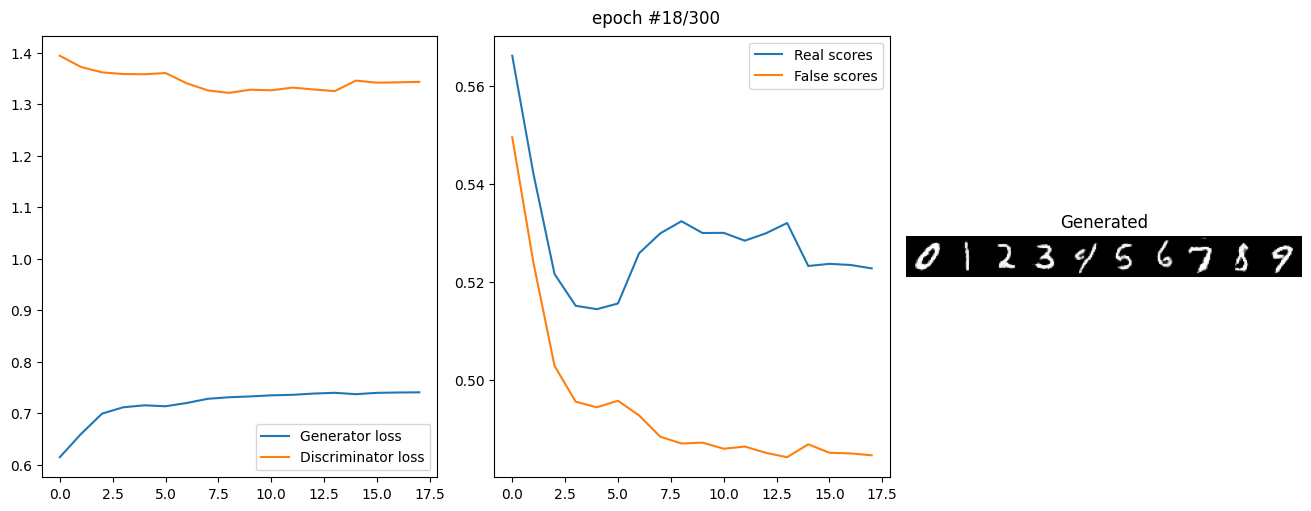

batch iterations:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [154]:
losses_g, losses_d, real_scores, fake_scores = train_gan(
    model=model,
    loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=300,
    device=DEVICE,
    log_step=1
)

In [155]:
torch.save(generator.state_dict(), 'cgan.ckpt')

---

### 2.3. [5 баллов]
### Формулировка задания:

1. Реализуй функцию `show_grid_gan(...)`, используя шаблон ниже

2. Визуализируй результат для `digit=8, n_reps=9`

3. Добавь код загрузки весов обученной модели, чтобы проверяющему было удобно воспроизвести твой код

In [230]:
@torch.no_grad
def show_grid_gan(model=None, digit=0, n_reps=1, device=None):
    """
    Визуализатор семлов CGAN.
            Параметры:
                    model torch.nn.Module: модель CVAE
                    digit (int): генерируемая цифра
                    n_reps (int): кол-во семплов
                    device torch.device: девайс
            Возвращаемое значение:
                    None
    """
    model.to(device)
    model.eval()

    targets = (torch.ones(n_reps) * digit).long()
    grid = model(batch_size=n_reps, targets=targets.to(device), device=device).cpu()

    plt.imshow(
        make_grid((grid + 1) / 2, nrow=np.sqrt(n_reps).astype(int)).permute(1, 2, 0),
    )

    plt.axis('off')
    plt.show()

Пример:

In [229]:
checkpoint = torch.load('cgan.ckpt', map_location='cpu')

model = Generator(
    latent_dim=LATENT_DIM,
    num_channels=NUM_CHANNELS,
    num_filters=NUM_FILTERS,
    im_dim=28,
    num_classes=10,
    activation=nn.LeakyReLU(0.2)
)
model.load_state_dict(checkpoint)

<All keys matched successfully>

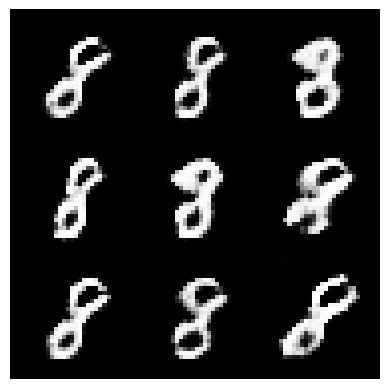

In [231]:
show_grid_gan(
    model,
    digit=8,
    n_reps=9,
    device=DEVICE
)

---

### 2.4. [30 баллов]
### Формулировка задания:

1. Реализуй функцию ```compute_acc_gan(...)```, используя шаблон ниже

Итоговый балл за этот пункт рассчитывается по формуле:

- int(mean_acc * 30), где mean_acc лежит в [0, 1]

In [232]:
from tqdm.notebook import tqdm
import numpy as np

from lenet import LeNet5

classiffier_model = LeNet5().eval()
classiffier_model.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth', weights_only=True))
classiffier_model = classiffier_model.to(DEVICE)

transform = TT.Compose([
    TT.Resize(size=(32, 32), antialias=True)
])

In [233]:
@torch.no_grad
def compute_acc_gan(model=None, n_reps=1, device=None):
    """
    CGAN accuracy.
    Алгоритм:
        1. цикл по цифрам
            a. генерируем n_reps цифр с одинаковым лейблом D
            b. считаем accuracy классификатора classiffier_model (в идеале все предикты должны быть D)
            с. сохраняем результат усредненной метрики в буфер 
        
        2. Считаем (mean, std) для получившегося буфера
        3. Возвращаем (mean, std)

            Параметры:
                    model torch.nn.Module: модель CVAE
                    n_reps (int): кол-во семплов
                    device torch.device: девайс
            Возвращаемое значение:
                    (mean, std) рассчитаные по цифрам
    """
    
    model.to(device)
    model.eval()

    scores = []
    
    for class_id in tqdm(range(10)):

        targets = (torch.ones(n_reps) * class_id).long()
        generated = model(batch_size=n_reps, targets=targets.to(device), device=device)

        input_ = (transform(generated)  + 1) / 2

        preds = F.softmax(
            classiffier_model(input_),
            dim=1
        ).cpu().numpy()

        acc = (preds.argmax(1) == targets.numpy()).astype(int).sum() / n_reps
        scores.append(acc)

    return np.mean(scores), np.std(scores)

In [235]:
checkpoint = torch.load('cgan.ckpt', map_location='cpu')

model = Generator(
    latent_dim=LATENT_DIM,
    num_channels=NUM_CHANNELS,
    num_filters=NUM_FILTERS,
    im_dim=28,
    num_classes=10,
    activation=nn.LeakyReLU(0.2)
)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [236]:
mu, sigma = compute_acc_gan(
    model=model,
    n_reps=100,
    device=DEVICE
)

mu, sigma

  0%|          | 0/10 [00:00<?, ?it/s]

(0.9259999999999999, 0.15882065356873457)

---